**Additional PS: Decision Making**

Planning Algorithms in AI

Kashirin Aleksandr

Skoltech 2021

**Problem Description: Escape the Maze**

In this problem set you are asked to play the game of Escape the Maze. The environment is a simple 2d grid world with some obstacles. In this game, there are two players, one is the evader (yellow dot) who wants to escape the maze by reaching the goal state. The second player, the pursuer (green dot) who wants to catch the evader.

**Task 1: Value Iteration**

In this task, you will calculate the optimal policy for the evader to move. For now, the pursuer remains static.

In [1]:
# Import libraries
import numpy as np
from matplotlib import pyplot as plt
import scipy as sp
from utils import plot_joint_enviroment, action_space, transition_function, pursuer_transition
from vi import vi
import matplotlib.animation as animation
#%matplotlib widget

# Control flags
labelsize = 14
titlesize = 16
suptitlesize = 18

Visualization of the workspace

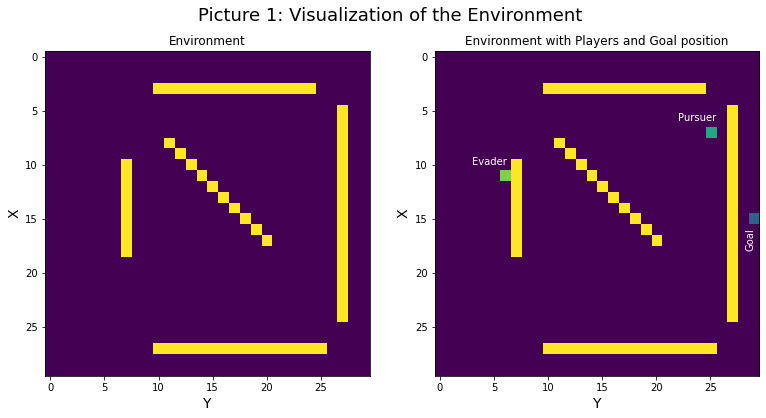

In [2]:
# Load the data
data = np.load("data_ps3.npz")
environment = data['environment']

# Plot the environment
plt.figure(figsize=[6.4*2, 6])
plt.suptitle('Picture 1: Visualization of the Environment', fontsize=suptitlesize)

# Plot the environment
plt.subplot(1, 2, 1)
plt.imshow(environment)
plt.title('Environment')
plt.xlabel('Y', fontsize=labelsize)
plt.ylabel('X', fontsize=labelsize)

# Define goal state and initial state
X_evader = (11, 6)
X_pursuer = (7, 25)
X_goal = (15, 29)

# Plot the Environment with goal and initial states
plt.subplot(1, 2, 2)
im = plot_joint_enviroment(environment, X_evader, X_pursuer, X_goal)
plt.imshow(im)
plt.title('Environment with Players and Goal position')
plt.text(X_evader[1] - 3, X_evader[0] - 1, "Evader", c='white')
plt.text(X_pursuer[1] - 3, X_pursuer[0] - 1, "Pursuer", c='white')
plt.text(X_goal[1], X_goal[0] + 3, "Goal", c='white', rotation='vertical', rotation_mode='anchor')
plt.xlabel('Y', fontsize=labelsize)
plt.ylabel('X', fontsize=labelsize)

plt.show()

**A: Enumerate the action space. The coordinates of actions are u = (row; column).**

In [3]:
action_names = ['Up', 'Left', 'Down', 'Right']
for i in range(len(action_space)):
    print(action_names[i], ":", action_space[i])

# Define dictionary with action names and spaces
actions = dict(zip(action_space, action_names))

Up : (-1, 0)
Left : (0, -1)
Down : (1, 0)
Right : (0, 1)


**B. Formulate the optimal cost-to-go G∗ in recursive form**

$G_k^* = min_{u_k}(l(x_k, u_k) + G_{k+1}^*(f(x_k, u_k)))$

**C. Implement the VI algorithm for infinite length sequences. To show this, you are asked to include a picture of the final G∗**

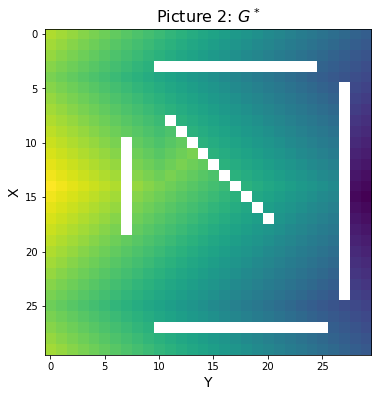

In [4]:
def implement_value_iteration(env, goal, N=100, action_space=action_space):
    """ Function returns a 2D matrix with cost-to-go to the desired goal position
    
    Args:
        env - The grid environment
        goal - The goal state
        N - Limit of iterations for the while cycle
        action_space - Space of possible actions for the entity
        
    Returns:
        G - 2D matrix with cost-to-go to the desired goal position
    """
    # Initialize action cost
    action_cost = 1
    # Initialize G graph
    G = np.zeros(env.shape)
    G[:] = np.inf
    G[goal] = 0
    # Initialize counter
    counter = 0
    # Initialize flag of G change
    flag = True
    # While there is a change in G graph
    while flag == True:
        # If the G graph was not changed
        if flag == False:
            # Then break the cycle
            break
        # If counter reached it is limit
        if counter == N:
            # Then break the cycle
            break
        # Increment the counter
        counter += 1
        # Set flag to False
        flag = False
        # Calculate G
        # For each X, Y
        for x in range(env.shape[0]):
            for y in range(env.shape[1]):
                # Check if G[X,Y] != inf
                if G[x, y] != np.inf:
                    # Assign the state
                    state = (x, y)
                    # For each action
                    for action in action_space:
                        # Calculate new state
                        new_state, is_action = transition_function(env, state, action)
                        # If action is possible
                        if is_action:
                            # Than compare current cost in the cell of new_state 
                            # with the cost of previous state + action cost
                            G[new_state] = min(G[new_state], G[state] + action_cost)
                            # Set flag True, as we modified G matrix
                            flag = True
    return G

G_star = implement_value_iteration(environment, X_goal)

# Plot the Heatmap of the matrix
plt.figure(figsize=[6.4, 6])
plt.imshow(G_star)
plt.title(r'Picture 2: $G^*$', fontsize=titlesize)
plt.xlabel('Y', fontsize=labelsize)
plt.ylabel('X', fontsize=labelsize)
plt.show()

In [5]:
def implement_policy_VI(G, env=environment, actions=actions, action_space=action_space):
    """ Function calculate a policy for cost-to-go 2d-matrix

    Args:
        G - 2D matrix with cost-to-go to the desired goal position
        env - Environment workspace
        actions - Dictionary with possible actions and coordinates {coordinates:name}

    Returns:
        policy - 2D matrix with names of actions to perform towards goal state
    """
    # Initialize policy matrix
    policy = np.chararray(G.shape, itemsize=5)
    # For each cell in cost-to-go matrix
    for x in range(G.shape[0]):
        for y in range(G.shape[1]):
            # Assign the current state
            state = (x, y)
            # For each action
            for action in action_space:
                # Calculate new state
                new_state, is_action = transition_function(env, state, action)
                # If action is possible
                if is_action:
                    # Than check if the value in the state is more
                    # then in the new_state
                    if G[state] > G[new_state]:
                        # Calculate differences between states
                        diff = tuple(np.array(new_state) - np.array(state))
                        # Pick the name of the movement from actions dictionary
                        # and assign the name of this movement to cell of policy table
                        policy[state] = actions[diff]
                        # if we already changed the cell, than omit other actions
                        break
    return policy

P = implement_policy_VI(G_star)

In [6]:
# Define functions to calculate plan
def get_plan(X_init, X_goal, policy, actions=actions):
    """ Function returns plan according to the obtained policy

    Args:
        X_init - Initial state
        X_goal - Goal state
        policy - Obtained policy
        actions - Dictionary with possible actions and coordinates {coordinates:name}

    Returns:
        plan - Path plan
    """
    # Invert actions dictionary
    inverted_actions = {name:coordinates for coordinates, name in actions.items()}
    # Initialize plan
    plan = []
    # Initialize first state
    state = X_init
    # While we have not reached the goal state
    while state != X_goal:
        # If we are reached the goal state
        if state == X_goal:
            # Break the cycle
            break
        # Append node in the plan
        plan.append(state)
        # Get the direction in the policy of the current state
        direction = policy[state].decode('ascii')
        # Get the coordinates according to the inverted dictionary
        coordinates = inverted_actions[direction]
        # Get the new state
        state = tuple(np.array(state) + np.array(coordinates))
    # Append the last state
    plan.append(X_goal)
    return plan

plan = get_plan(X_evader, X_goal, P)

MovieWriter ffmpeg unavailable; using Pillow instead.


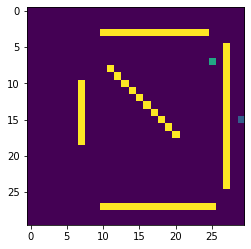

In [7]:
# Visualization of the algorithm
fig = plt.figure()
imgs = []
for X in plan:
    im = plot_joint_enviroment(environment, X, X_pursuer, X_goal)
    plot = plt.imshow(im)
    imgs.append([plot])

ani = animation.ArtistAnimation(fig, imgs, interval=100, blit=True)
ani.save('plan_vi.gif')
plt.show()

**C: Un-comment the pursuer transition function. Did you escape?**

MovieWriter ffmpeg unavailable; using Pillow instead.


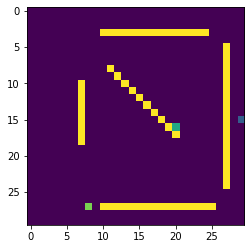

In [42]:
# Visualization of the algorithm
fig = plt.figure()
imgs = []
pursuer_state = X_pursuer
for X in plan:
    pursuer_state = pursuer_transition(environment, X, pursuer_state)
    im = plot_joint_enviroment(environment, X, pursuer_state, X_goal)
    plot = plt.imshow(im)
    imgs.append([plot])

ani = animation.ArtistAnimation(fig, imgs, interval=200, blit=True)
ani.save('plan_purs.gif')
plt.show()

**Comment: No, I did not escape.**

**Task 2: Monte Carlo Tree Search**

In [48]:
def implement_MCTS(env, X_evader, X_pursuer, X_goal, action_space=action_space, N=1, sim=3):
    """ Function returns optimal plan for the evader using
        Monte Carlo Tree Search (MCTS) algorithm

    Description:
        MCTS has four states:
            Expansion - makes potential move for the current node
            Simulation - does given amount of simulations from the expanded node
            Update - counts amount of [win/simulation] and updates this number for all parent nodes
            Selection - selects the most promising node and then starts the algorithm again
        
        For more information: https://www.youtube.com/watch?v=Fbs4lnGLS8M&ab_channel=FullstackAcademy

    Args:
        env - The grid environment
        X_evader - Initial position for the evader
        X_pursuer - Initial position for the pursuer
        X_goal - Goal state for the evader
        action_space - List of tuples of possible actions
        N - Maximum amount of iterations
        sim - Amount of desired simulations from the node

    Returns:
        plan - Optimal path plan for the evader
    """
    # Initialize plan
    plan = []
    # Initialize current position of the evader
    evader_state = X_evader
    # Initialize current position of the pursuer
    pursuer_state = X_pursuer
    # Parent table for the evader {child:parent}
    parent_table = {}
    # Initialize win flag
    win = False
    # Initialize defeat flag
    defeat = False
    # Initialize win/simulation table {(x,y):(wins,defeats)}
    win_sim_table = {X_evader:(0, 0)}
    # Initialize win increment, increase win and simulation counters
    win_increment = np.array([1, 1])
    # Initialize defeat increment, increase simulation counters
    defeat_increment = np.array([0, 1])
    # Initialize selection table {(x,y):selection_number}
    selection_table = {}
    # Initialize simulation counter
    sim_counter = 0
    # Initialize counter of iterations
    counter = 0
    # Initialize list of potential expansion children where actions could be expanded
    expansion_children = []
    # Initialize pursuer parent table {Evader previous state (x,y)):Pursuer state (x,y)}
    pursuer_parent_table = {X_evader: X_pursuer}

    # While evader state != X_goal
    while evader_state != X_goal:
        # If evader state == X_goal
        if evader_state == X_goal:
            # Then break the cycle
            break
        # If counter == N
        if counter == N:
            # Then break the cycle
            break
        # Increase the counter of iterations
        counter += 1

        """Expansion"""
        # Reset list of expanded actions from previous iteration
        expansion_children = []
        # For each action in action space
        for action in action_space:
            # Calculate evader new state
            evader_new_state, is_action = transition_function(env, evader_state, action)
            # If action is possible
            if is_action:
                # Check if the evader_new_state not in parent_table
                if evader_new_state not in parent_table:
                    # Then add this state into parent table
                    parent_table[evader_new_state] = evader_state
                    # Add this expanded child to the list where the simulation phase could be started
                    expansion_children.append(evader_new_state)
                # Check if the evader_new_state not in win_sim_table
                if evader_new_state not in win_sim_table:
                    # Add in win_sim_table new node
                    win_sim_table[evader_new_state] = (0, 0)

        """Simulation"""
        # Assign last evader state
        last_evader_state = evader_state
        # Get last pursuer state
        if pursuer_parent_table: # If list is non-empty
            pursuer_state = pursuer_parent_table[last_evader_state]
        # For each child node of the evader
        for child in expansion_children:
            # Put new state into pursuer parent table
            pursuer_parent_table[child] = pursuer_transition(environment, child, pursuer_state)
            # For each simulation
            for i in range(sim):
                # Assign evader state
                evader_state = child
                # Increment simulation counter
                sim_counter += 1
                # While win or defeat in current simulation was not reached
                while (win != True) or (defeat != True):
                    # If win or defeat was reached
                    if (win == True) or (defeat == True):
                        # Then break the cycle and go to the next simulation
                        break
                    # Get new pursuer state
                    pursuer_new_state = pursuer_transition(environment, evader_state, pursuer_state)
                    # Check win/defeat 
                    # Criterion of win/defeat:
                    # If coordinates of pursuer == coordinates of evader
                    if pursuer_new_state == evader_new_state:
                        # Then defeat
                        defeat = True
                    # else if cooordinates of pursuer != coordinates of evader and evader reached his goal
                    elif (pursuer_new_state != evader_new_state) and (evader_new_state == X_goal):
                        # Then win
                        win = True
                    # else coordinates of pursuer != coordinates of evader and evader did not reach his goal state
                    else:
                        # Generate new random action for the evader
                        rand_action_ind = np.random.randint(0, len(action_space))
                        # Assign new state
                        action = action_space[rand_action_ind]
                        # Calculate evader new state
                        evader_new_state, is_action = transition_function(env, evader_state, action)
                        # If action is possible
                        if is_action:
                            # Reassign new_evader_state to evader_state
                            evader_state = evader_new_state
                            # Reassign pursuer_new_state to pursuer_state
                            pursuer_state = pursuer_new_state
                """Update"""
                # When win or defeat was reached, we need to update the corresponding numbers
                # If simulation was successful
                if win:
                    # Assign node as current child
                    node = child
                    # While the starting node was not reached
                    while True:
                        # Update current node for win count and simulation count
                        win_sim_table[node] = tuple(np.array(win_sim_table[node]) + win_increment)
                        # Assign new child node
                        node = parent_table[node]
                        # If starting point was reached
                        if node == X_evader:
                            # Update current node for win count and simulation count
                            win_sim_table[node] = tuple(np.array(win_sim_table[node]) + win_increment)
                            # Then break the cycle
                            break
                    # Reset win flag
                    win = False
                    # Get last pursuer state
                    if pursuer_parent_table: # If list is non-empty
                        pursuer_state = pursuer_parent_table[last_evader_state]
                    else:
                        pursuer_state = X_pursuer
                # Else simulation was unsuccessful
                elif defeat:
                        # Assign node as current child
                        node = child
                        # While the starting node was not reached
                        while True:
                            # Update current node for simulation count
                            win_sim_table[node] = tuple(np.array(win_sim_table[node]) + defeat_increment)
                            # Assign new child node
                            node = parent_table[node]
                            # If starting point was reached
                            if node == X_evader:
                                # Update current node for simulation count
                                win_sim_table[node] = tuple(np.array(win_sim_table[node]) + defeat_increment)
                                # Then break the cycle
                                break
                        # Reset defeat flag
                        defeat = False
                        # Get last pursuer state
                        if pursuer_parent_table: # If list is non-empty
                            pursuer_state = pursuer_parent_table[last_evader_state]
                        else:
                            pursuer_state = X_pursuer
        """Selection"""
        # For each node in win_sim_table
        for coord, win_sim in win_sim_table.items():
            # N = (Win/Sim) + sqrt(2*ln(n)/n_i)
            selection_number = (win_sim[0]/win_sim[1]) + np.sqrt((2 * np.log(win_sim[1])) / sim_counter)
            # Add selection number into the selection table
            selection_table[coord] = selection_number
        # Pick the most promissing node
        # Set current node as starting state
        current_node = X_evader
        # Initialize dictionary with current children for the current parent
        current_children = dict() # {child:selection_number}
        # Initialize pick flag of the node
        pick_flag = False
        # While the  most promissing was not chosen
        while pick_flag != True:
            # Create a dictionary with childs of the current node
            for key, value in parent_table.items():
                if value == current_node:
                    current_children[key] = selection_table[key]
            # Check if childs list is empty
            # If not empty
            if current_children:
                # Pick the most promissing child
                current_node = max(current_children)
                # Reset childs list
                current_children = dict()
            # If empty
            elif not current_children:
                # Best child was reached
                pick_flag = True
                print(current_node)
                plan.append(current_node)
                # Start simulation from this node
                evader_state = current_node
        
        """
        # Extrude starting point from the selection table
        sel_num_X_evader = selection_table.pop(X_evader)
        # Make a selection of the most promising node
        evader_state = max(selection_table, key=selection_table.get)
        """

    """Return a path plan"""
    # Check if evader_state reached the goal state
    if evader_state == X_goal:
        print('Success')
    else:
        print('Failure')

    # Return path plan
    #return win_sim_table, selection_table, evader_state, sim_counter
    return selection_table, parent_table, plan, pursuer_parent_table, win_sim_table
selection_table, parent_table, plan, pursuer_parent_table, win_sim_table = implement_MCTS(environment, X_evader, X_pursuer, X_goal, N=100, sim=5)

(12, 6)
(13, 6)
(14, 6)
(15, 6)
(16, 6)
(17, 6)
(18, 6)
(19, 6)
(20, 6)
(21, 6)
(22, 6)
(23, 6)
(24, 6)
(25, 6)
(26, 6)
(27, 6)
(28, 6)
(29, 6)
(29, 7)
(29, 8)
(29, 9)
(29, 10)
(29, 11)
(29, 12)
(29, 13)
(29, 14)
(29, 15)
(29, 16)
(29, 17)
(29, 18)
(29, 19)
(29, 20)
(29, 21)
(29, 22)
(29, 23)
(29, 24)
(29, 25)
(29, 26)
(29, 27)
(29, 28)
(29, 29)
(28, 29)
(27, 29)
(27, 28)
(27, 27)
(27, 26)
(26, 26)
(26, 25)
(26, 24)
(26, 23)
(26, 22)
(26, 21)
(26, 20)
(26, 19)
(26, 18)
(26, 17)
(26, 16)
(26, 15)
(26, 14)
(26, 13)
(26, 12)
(26, 11)
(26, 10)
(26, 9)
(27, 9)
(27, 8)
(27, 8)
(27, 8)
(27, 8)
(27, 8)
(27, 8)
(27, 8)
(27, 8)
(27, 8)
(27, 8)
(27, 8)
(27, 8)
(27, 8)
(27, 8)
(27, 8)
(27, 8)
(27, 8)
(27, 8)
(27, 8)
(27, 8)
(27, 8)
(27, 8)
(27, 8)
(27, 8)
(27, 8)
(27, 8)
(27, 8)
(27, 8)
(27, 8)
(27, 8)
(27, 8)
(27, 8)
(27, 8)
(27, 8)
(27, 8)
Failure


In [47]:
np.random.seed(1)

In [37]:
selection_table

{(11, 6): 0.20780773382479134,
 (10, 6): 0.06781145947054967,
 (11, 5): 0.06781145947054967,
 (12, 6): 0.20912488807112067,
 (12, 5): 0.06781145947054967,
 (13, 6): 0.21050524657898356,
 (13, 5): 0.06781145947054967,
 (14, 6): 0.21146276625986285,
 (14, 5): 0.06781145947054967,
 (15, 6): 0.2124517448461038,
 (15, 5): 0.06781145947054967,
 (16, 6): 0.21347368221786228,
 (16, 5): 0.06781145947054967,
 (17, 6): 0.21453017393316334,
 (17, 5): 0.06781145947054967,
 (18, 6): 0.21562291894109936,
 (18, 5): 0.06781145947054967,
 (19, 6): 0.21675372805145024,
 (19, 5): 0.2678114594705497,
 (20, 6): 0.20852557376171788,
 (19, 7): 1.0678114594705497,
 (20, 5): 0.06781145947054967,
 (21, 6): 0.2015911095145262,
 (20, 7): 0.06781145947054967,
 (21, 5): 0.06781145947054967,
 (22, 6): 0.20307018780283587,
 (21, 7): 0.06781145947054967,
 (22, 5): 0.06781145947054967,
 (23, 6): 0.20463616851347816,
 (22, 7): 0.06781145947054967,
 (23, 5): 0.06781145947054967,
 (24, 6): 0.20629649949907158,
 (23, 7): 0.

In [38]:
win_sim_table

{(11, 6): (50, 705),
 (10, 6): (0, 5),
 (11, 5): (0, 5),
 (12, 6): (50, 690),
 (12, 5): (0, 5),
 (13, 6): (50, 675),
 (13, 5): (0, 5),
 (14, 6): (50, 665),
 (14, 5): (0, 5),
 (15, 6): (50, 655),
 (15, 5): (0, 5),
 (16, 6): (50, 645),
 (16, 5): (0, 5),
 (17, 6): (50, 635),
 (17, 5): (0, 5),
 (18, 6): (50, 625),
 (18, 5): (0, 5),
 (19, 6): (50, 615),
 (19, 5): (1, 5),
 (20, 6): (44, 600),
 (19, 7): (5, 5),
 (20, 5): (0, 5),
 (21, 6): (39, 585),
 (20, 7): (0, 5),
 (21, 5): (0, 5),
 (22, 6): (39, 570),
 (21, 7): (0, 5),
 (22, 5): (0, 5),
 (23, 6): (39, 555),
 (22, 7): (0, 5),
 (23, 5): (0, 5),
 (24, 6): (39, 540),
 (23, 7): (0, 5),
 (24, 5): (0, 5),
 (25, 6): (39, 525),
 (24, 7): (0, 5),
 (25, 5): (0, 5),
 (26, 6): (39, 510),
 (25, 7): (0, 5),
 (26, 5): (0, 5),
 (27, 6): (39, 495),
 (26, 7): (0, 5),
 (27, 5): (0, 5),
 (28, 6): (39, 480),
 (27, 7): (0, 5),
 (28, 5): (0, 5),
 (29, 6): (39, 465),
 (28, 7): (0, 5),
 (29, 5): (0, 5),
 (29, 7): (39, 455),
 (29, 8): (39, 450),
 (28, 8): (0, 5),
 

In [11]:
plan


[(12, 6),
 (13, 6),
 (14, 6),
 (15, 6),
 (16, 6),
 (17, 6),
 (18, 6),
 (19, 6),
 (20, 6),
 (21, 6),
 (22, 6),
 (23, 6),
 (24, 6),
 (25, 6),
 (26, 6),
 (27, 6),
 (28, 6),
 (29, 6),
 (29, 7),
 (29, 8),
 (29, 9),
 (29, 10),
 (29, 11),
 (29, 12),
 (29, 13),
 (29, 14),
 (29, 15),
 (29, 16),
 (29, 17),
 (29, 18),
 (29, 19),
 (29, 20),
 (29, 21),
 (29, 22),
 (29, 23),
 (29, 24),
 (29, 25),
 (29, 26),
 (29, 27),
 (29, 28),
 (29, 29),
 (28, 29),
 (27, 29),
 (27, 28),
 (27, 27),
 (27, 26),
 (26, 26),
 (26, 25),
 (26, 24),
 (26, 23),
 (26, 22),
 (26, 21),
 (26, 20),
 (26, 19),
 (26, 18),
 (26, 17),
 (26, 16),
 (26, 15),
 (26, 14),
 (26, 13),
 (26, 12),
 (26, 11),
 (26, 10),
 (26, 9),
 (27, 9),
 (27, 8),
 (27, 8),
 (27, 8),
 (27, 8),
 (27, 8),
 (27, 8),
 (27, 8),
 (27, 8),
 (27, 8),
 (27, 8),
 (27, 8),
 (27, 8),
 (27, 8),
 (27, 8),
 (27, 8),
 (27, 8),
 (27, 8),
 (27, 8),
 (27, 8),
 (27, 8),
 (27, 8),
 (27, 8),
 (27, 8),
 (27, 8),
 (27, 8),
 (27, 8),
 (27, 8),
 (27, 8),
 (27, 8),
 (27, 8),
 (27, 8)

In [12]:
parent_table

{(10, 6): (11, 6),
 (11, 5): (11, 6),
 (12, 6): (11, 6),
 (11, 6): (12, 6),
 (12, 5): (12, 6),
 (13, 6): (12, 6),
 (13, 5): (13, 6),
 (14, 6): (13, 6),
 (14, 5): (14, 6),
 (15, 6): (14, 6),
 (15, 5): (15, 6),
 (16, 6): (15, 6),
 (16, 5): (16, 6),
 (17, 6): (16, 6),
 (17, 5): (17, 6),
 (18, 6): (17, 6),
 (18, 5): (18, 6),
 (19, 6): (18, 6),
 (19, 5): (19, 6),
 (20, 6): (19, 6),
 (19, 7): (19, 6),
 (20, 5): (20, 6),
 (21, 6): (20, 6),
 (20, 7): (20, 6),
 (21, 5): (21, 6),
 (22, 6): (21, 6),
 (21, 7): (21, 6),
 (22, 5): (22, 6),
 (23, 6): (22, 6),
 (22, 7): (22, 6),
 (23, 5): (23, 6),
 (24, 6): (23, 6),
 (23, 7): (23, 6),
 (24, 5): (24, 6),
 (25, 6): (24, 6),
 (24, 7): (24, 6),
 (25, 5): (25, 6),
 (26, 6): (25, 6),
 (25, 7): (25, 6),
 (26, 5): (26, 6),
 (27, 6): (26, 6),
 (26, 7): (26, 6),
 (27, 5): (27, 6),
 (28, 6): (27, 6),
 (27, 7): (27, 6),
 (28, 5): (28, 6),
 (29, 6): (28, 6),
 (28, 7): (28, 6),
 (29, 5): (29, 6),
 (29, 7): (29, 6),
 (29, 8): (29, 7),
 (28, 8): (29, 8),
 (29, 9): (2

In [13]:
selection_table

{(11, 6): 0.26588826574812446,
 (10, 6): 0.0,
 (11, 5): 0.0,
 (12, 6): 0.2653098911827236,
 (12, 5): 0.0,
 (13, 6): 0.2647174984350144,
 (13, 5): 0.0,
 (14, 6): 0.2643144536402955,
 (14, 5): 0.0,
 (15, 6): 0.2639046722696109,
 (15, 5): 0.0,
 (16, 6): 0.26348793424155315,
 (16, 5): 0.0,
 (17, 6): 0.2630640086817164,
 (17, 5): 0.0,
 (18, 6): 0.2626326532114581,
 (18, 5): 0.0,
 (19, 6): 0.2621936131774276,
 (19, 5): 0.0,
 (20, 6): 0.2615200550294387,
 (19, 7): 0.0,
 (20, 5): 0.0,
 (21, 6): 0.2608276369777492,
 (20, 7): 0.0,
 (21, 5): 0.0,
 (22, 6): 0.26011531641602165,
 (21, 7): 0.0,
 (22, 5): 0.0,
 (23, 6): 0.2593819632817411,
 (22, 7): 0.0,
 (23, 5): 0.0,
 (24, 6): 0.258626350086215,
 (23, 7): 0.0,
 (24, 5): 0.0,
 (25, 6): 0.2578471404910149,
 (24, 7): 0.0,
 (25, 5): 0.0,
 (26, 6): 0.25704287617005706,
 (25, 7): 0.0,
 (26, 5): 0.0,
 (27, 6): 0.25621196164042964,
 (26, 7): 0.0,
 (27, 5): 0.0,
 (28, 6): 0.2553526466748019,
 (27, 7): 0.0,
 (28, 5): 0.0,
 (29, 6): 0.2544630058196295,
 (28, 